In [313]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
!pip install tensorflow

     -------------------------------------- 376.9/376.9 MB 3.7 MB/s eta 0:00:00
     ---------------------------------------- 26.4/26.4 MB 5.2 MB/s eta 0:00:00
     -------------------------------------- 127.8/127.8 kB 1.9 MB/s eta 0:00:00
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
     ---------------------------------------- 1.1/1.1 MB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 5.9 MB/s eta 0:00:00
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
     -------------------------------------- 133.7/133.7 kB 2.7 MB/s eta 0:00:00
  Using cached wrapt-1.16.0-cp310-cp310-win_amd64.whl (37 kB)
     ---------------------------------------- 3.0/3.0 MB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 3.9 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl 


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [314]:
df = pd.read_csv('../data/web_response.csv', parse_dates=['point'], index_col='point')

In [315]:
df = df.head(10000)


In [316]:

train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(9000, 1) (1000, 1)


In [317]:
from sklearn.preprocessing import StandardScaler

value_key = 'web_response'

scaler = StandardScaler()
scaler = scaler.fit(train[[value_key]])

train[value_key] = scaler.transform(train[[value_key]])
test[value_key] = scaler.transform(test[[value_key]])


/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1646131435.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[value_key] = scaler.transform(train[[value_key]])
/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1646131435.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[value_key] = scaler.transform(test[[value_key]])


In [318]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [319]:
TIME_STEPS = 60

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[[value_key]], train[value_key], TIME_STEPS)
X_test, y_test = create_dataset(test[[value_key]], test[value_key], TIME_STEPS)

print(X_test.shape)

(940, 60, 1)


In [320]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

/Users/anatolyefimov/red-hack-time-series-analyzer/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [321]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.2864 - val_loss: 0.2081
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.2590 - val_loss: 0.2147
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.2567 - val_loss: 0.1863
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2502 - val_loss: 0.1973
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.2513 - val_loss: 0.1910
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.2484 - val_loss: 0.1921
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.2480 - val_loss: 0.1870
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.2462 - val_loss: 0.1880
Epoch 9/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2454 - val_loss: 0.1855
Epoch 10/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.2451 - val_loss: 0.1850


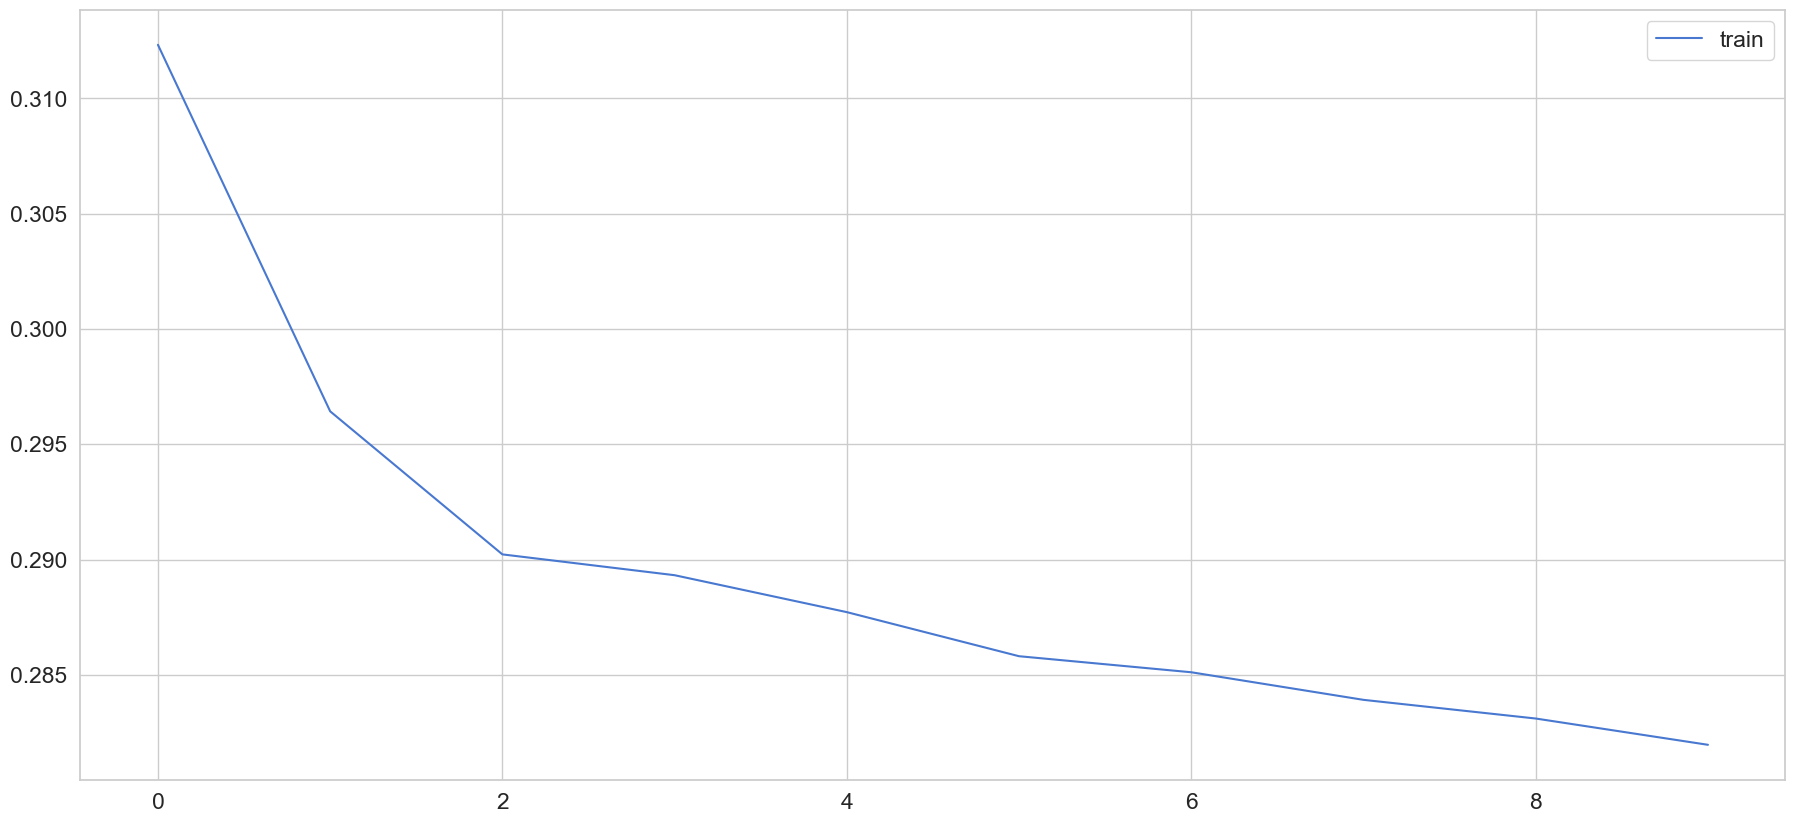

In [322]:
plt.plot(history.history['loss'], label='train')

plt.legend();

In [323]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1731640021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


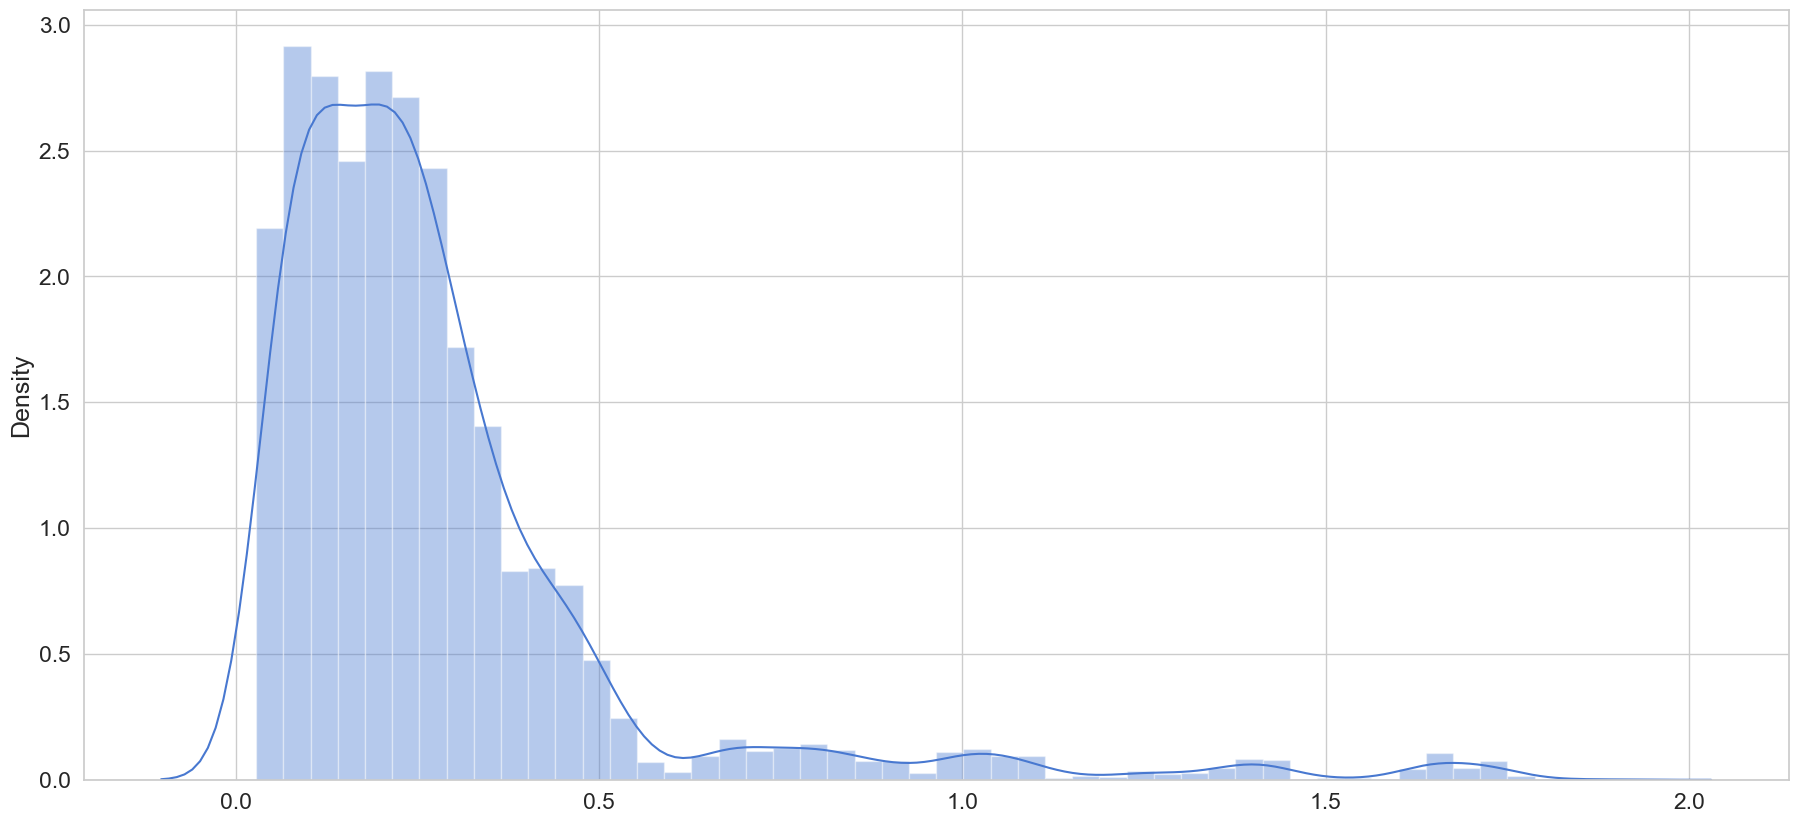

In [324]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [325]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


/var/folders/t8/drf96cn57_g4mp7xh4n29g200000gn/T/ipykernel_72622/1731640021.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_mae_loss, bins=50, kde=True);


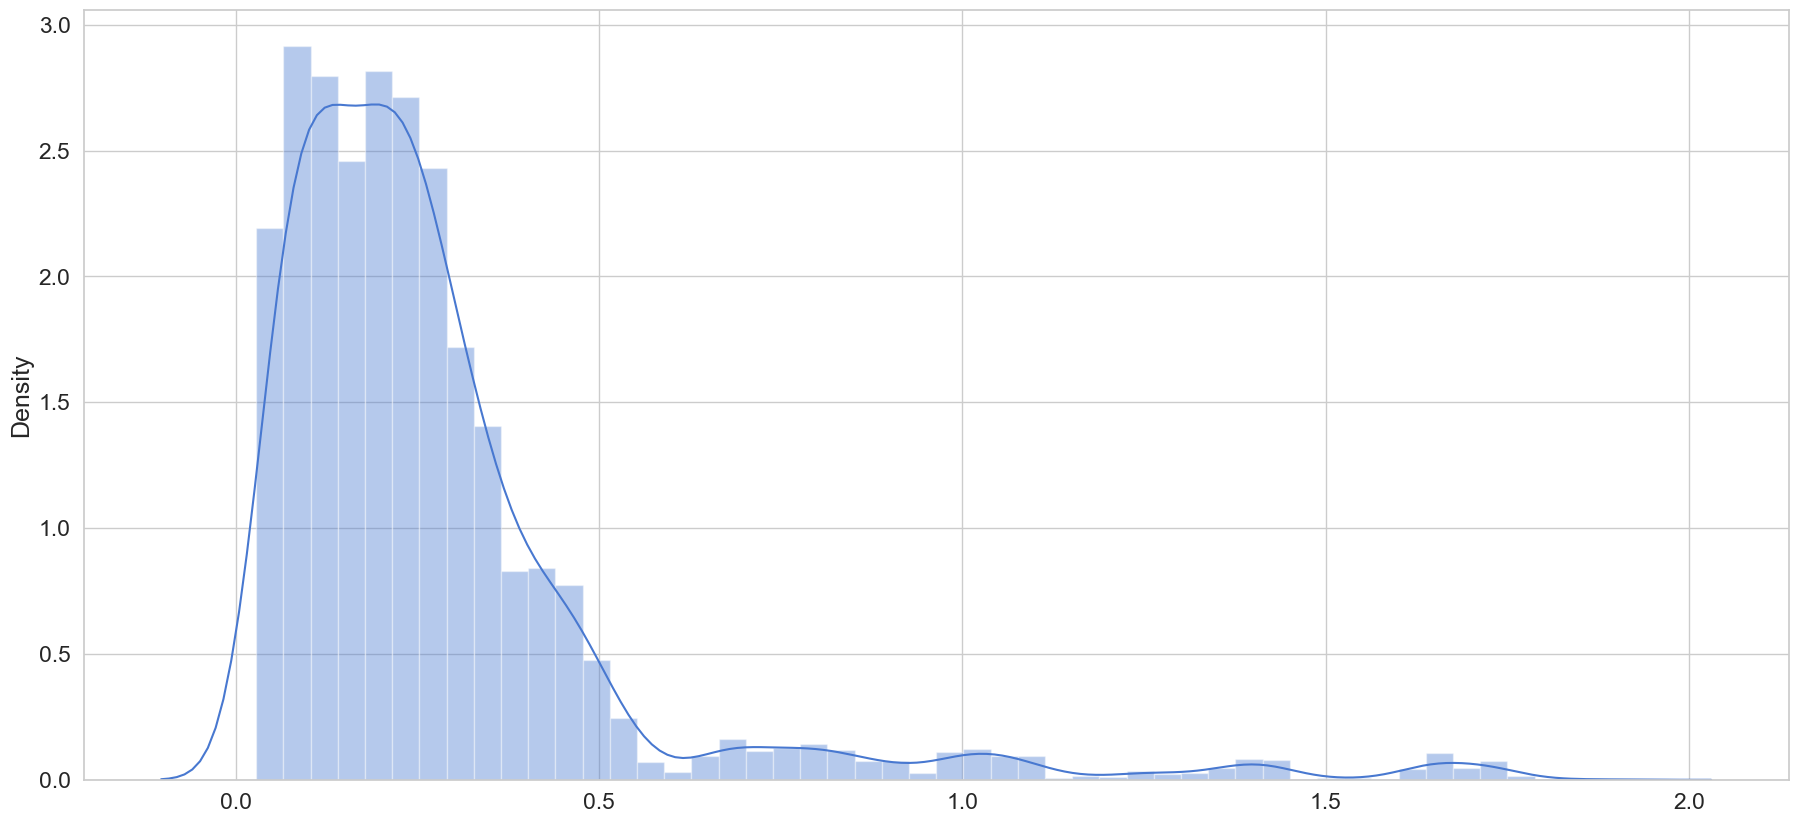

In [326]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [336]:
THRESHOLD = 0.4

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df[value_key] = test[TIME_STEPS:][value_key]

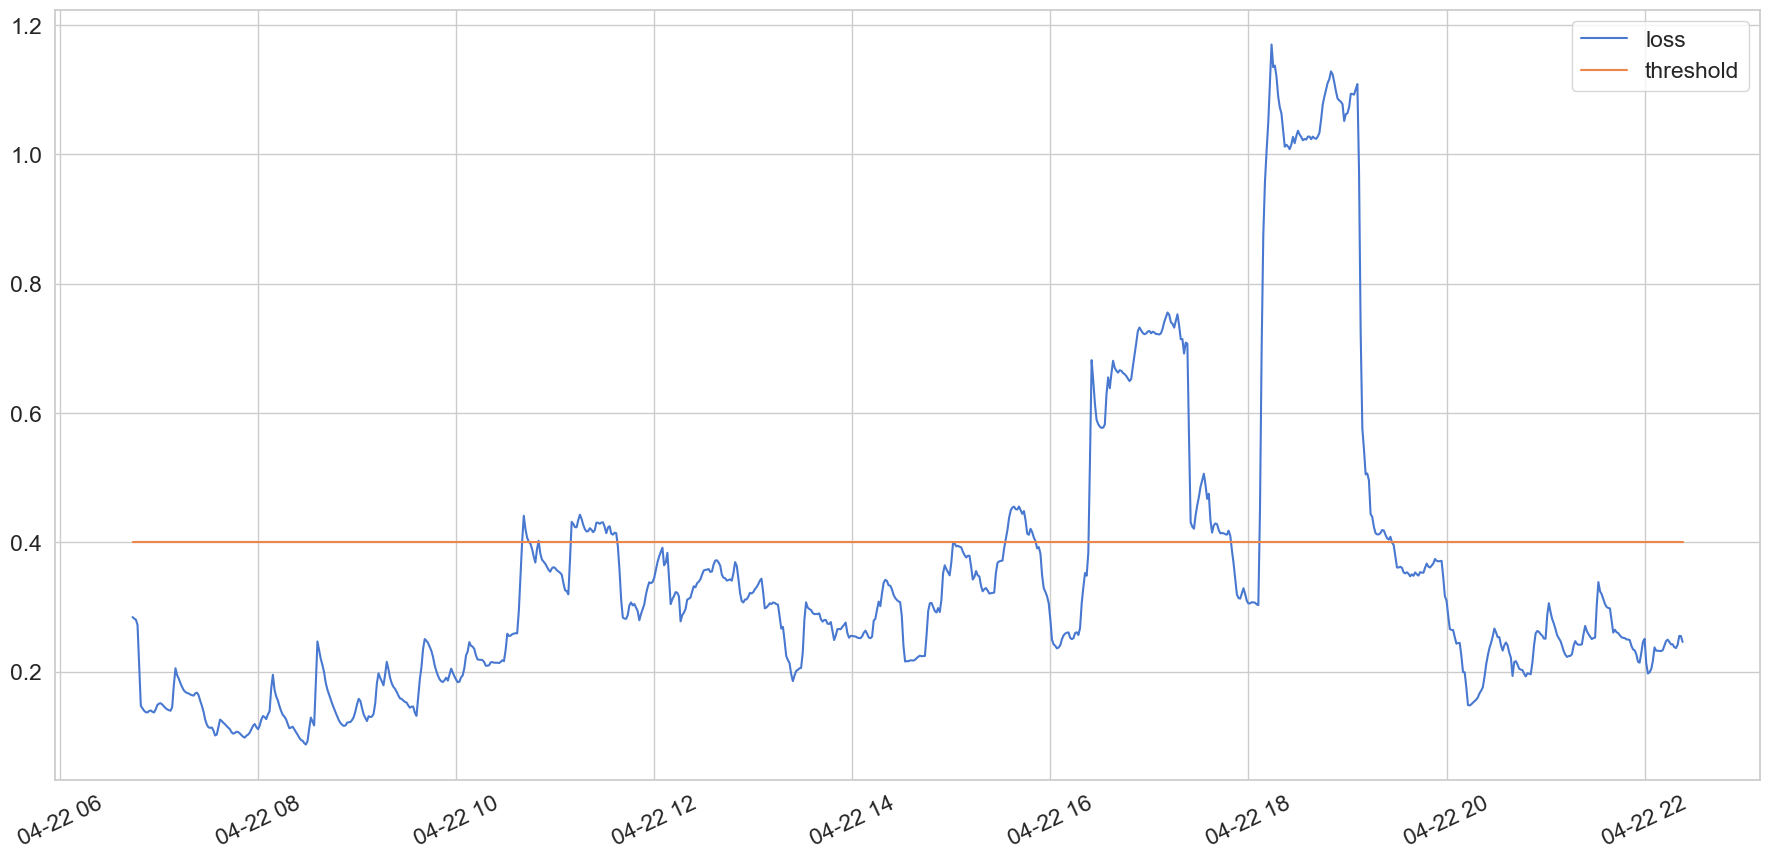

In [337]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [338]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,web_response
point,,,,
2024-04-22 10:40:00,0.400877,0.4,True,1.836870
2024-04-22 10:41:00,0.441242,0.4,True,0.084778
2024-04-22 10:42:00,0.420537,0.4,True,0.001439
2024-04-22 10:43:00,0.407561,0.4,True,0.061622
2024-04-22 10:44:00,0.400974,0.4,True,0.133212


                     web_response
point                            
2024-04-15 23:32:00      0.007722
2024-04-15 23:33:00      0.008363
2024-04-15 23:34:00      0.008709
2024-04-15 23:35:00      0.008286
2024-04-15 23:36:00      0.010874


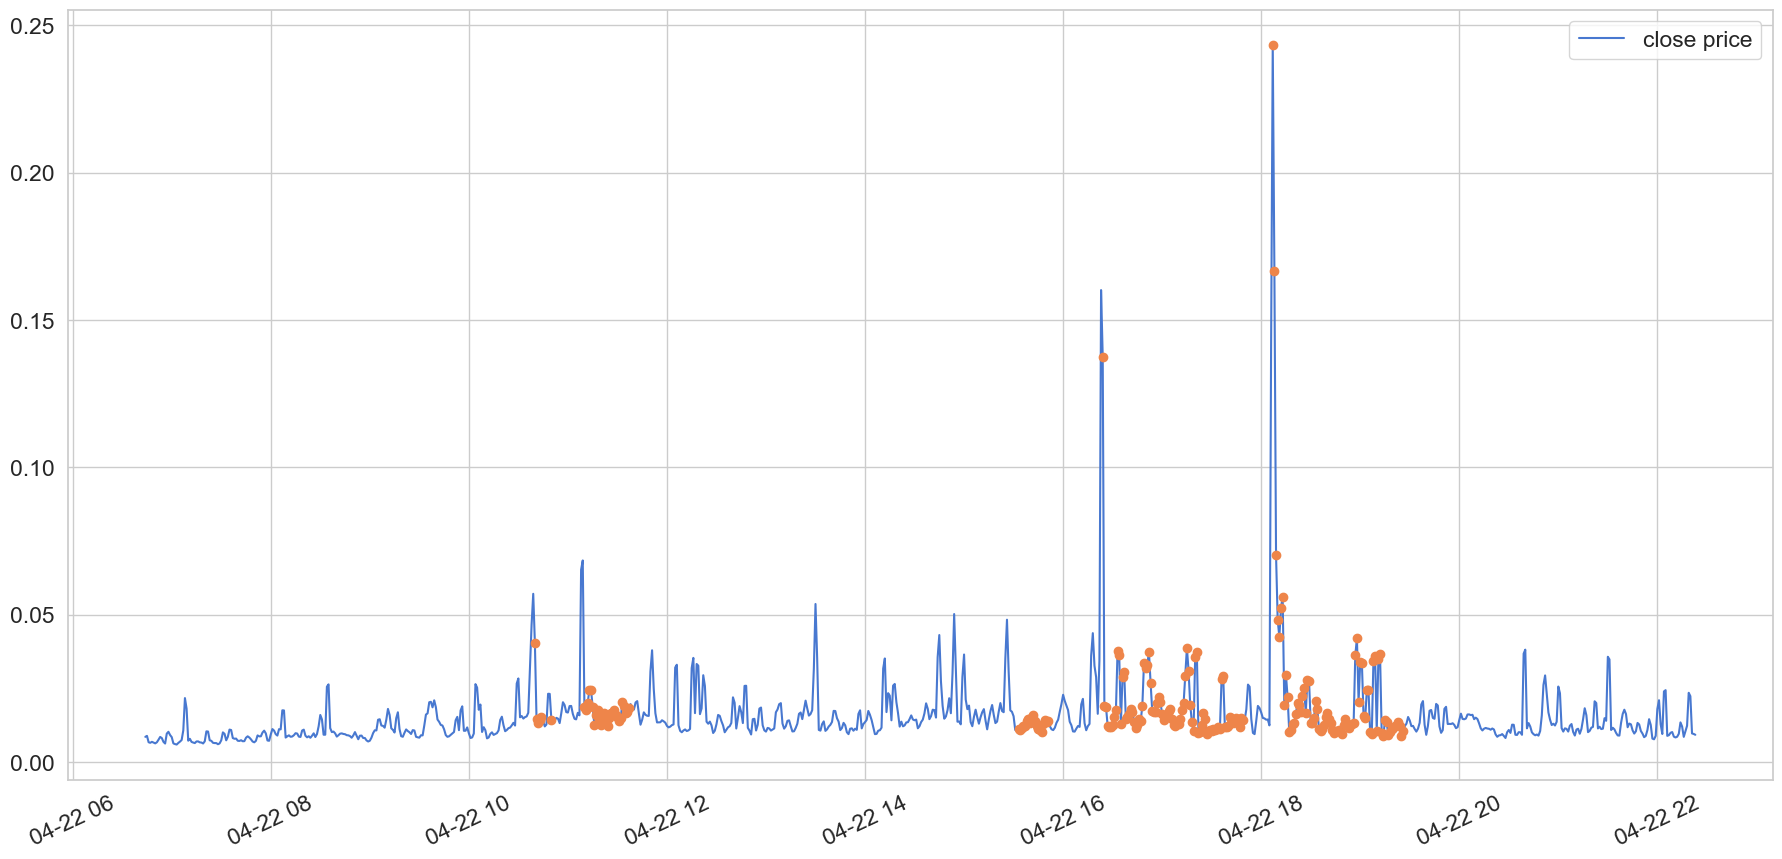

In [339]:

print(df.head())
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:][[value_key]]), 
  label='close price'
);


plt.plot(
  anomalies.index,
  scaler.inverse_transform(anomalies[[value_key]]),
 'o'
)
plt.xticks(rotation=25)
plt.legend();